In [143]:
import pandas as pd
import re
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**1. Data downloading and preprocesing**

In [144]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
# Відкрити і прочитати файл
file_path = '/content/drive/My Drive/Colab Notebooks/movie_ids.txt'

# Відкрити файл і прочитати його вміст як звичайний текстовий файл
with open(file_path, 'r', encoding='ISO-8859-1') as file:
    lines = file.readlines()


In [146]:
# Видалити пробіли з кінців рядків
lines = [line.strip() for line in lines]

lines [:5]


['1 Toy Story (1995)',
 '2 GoldenEye (1995)',
 '3 Four Rooms (1995)',
 '4 Get Shorty (1995)',
 '5 Copycat (1995)']

In [147]:
# Створення DataFrame з списку рядків
df = pd.DataFrame(lines, columns=['title'])

df.head()

,title
0,1 Toy Story (1995)
1,2 GoldenEye (1995)
2,3 Four Rooms (1995)
3,4 Get Shorty (1995)
4,5 Copycat (1995)


In [148]:
df['year'] = df['title'].map(lambda x: x[-5:-1])
df['title'] = df['title'].map(lambda x: x[:-7])

df

,title,year
0,1 Toy Story,1995
1,2 GoldenEye,1995
2,3 Four Rooms,1995
3,4 Get Shorty,1995
4,5 Copycat,1995
...,...,...
1677,1678 Mat' i syn,1997
1678,1679 B. Monkey,1998
1679,1680 Sliding Doors,1998
1680,1681 You So Crazy,1994


In [149]:
# Розділення номера та назви фільму на дві окремі колонки
df[['movie_id', 'title']] = df['title'].str.split(n= 1, expand=True)
df


,title,year,movie_id
0,Toy Story,1995,1
1,GoldenEye,1995,2
2,Four Rooms,1995,3
3,Get Shorty,1995,4
4,Copycat,1995,5
...,...,...,...
1677,Mat' i syn,1997,1678
1678,B. Monkey,1998,1679
1679,Sliding Doors,1998,1680
1680,You So Crazy,1994,1681


In [150]:
# Впорядковую стовпці
df = df[['movie_id', 'title', 'year']]
# Перевизначення значень стовпця 'movie_id' на 'movie_1', 'movie_2', і т.д.
df['movie_id'] = [f'movie_{i+1}' for i in range(df.shape[0])]
df

,movie_id,title,year
0,movie_1,Toy Story,1995
1,movie_2,GoldenEye,1995
2,movie_3,Four Rooms,1995
3,movie_4,Get Shorty,1995
4,movie_5,Copycat,1995
...,...,...,...
1677,movie_1678,Mat' i syn,1997
1678,movie_1679,B. Monkey,1998
1679,movie_1680,Sliding Doors,1998
1680,movie_1681,You So Crazy,1994


In [151]:
from scipy.io import loadmat
# Шлях до файлу .mat
file_path = '/content/drive/My Drive/Colab Notebooks/movies.mat'

# Завантажити дані з файлу .mat
data = loadmat(file_path)

# Вивести всі ключі (фічі) у змінній data
print(data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])


In [152]:
Y, R = data['Y'], data['R']
Y[:5]

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [153]:
R[:5]

array([[1, 1, 0, ..., 1, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]], dtype=uint8)

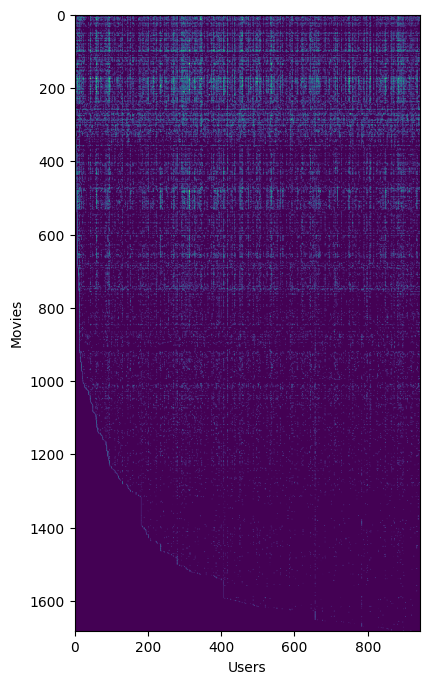

In [154]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.imshow(Y)
plt.ylabel('Movies')
plt.xlabel('Users')
plt.grid(False)

plt.show()


**2. Content based RS**

In [155]:
# Створення DataFrame користувачів. які проголосували за якійсь фільм

df_Y = pd.DataFrame(Y)

# Rename the columns to 'user_1', 'user_2', etc.
df_Y.columns = [f'user_{i+1}' for i in range(df_Y.shape[1])]

# Rename the index to 'movie_1', 'movie_2', etc.
df_Y.index = [f'movie_{i+1}' for i in range(df_Y.shape[0])]

df_Y.head(), df_Y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, movie_1 to movie_1682
Columns: 943 entries, user_1 to user_943
dtypes: uint8(943)
memory usage: 1.5+ MB


(         user_1  user_2  user_3  user_4  user_5  user_6  user_7  user_8  \
 movie_1       5       4       0       0       4       4       0       0   
 movie_2       3       0       0       0       3       0       0       0   
 movie_3       4       0       0       0       0       0       0       0   
 movie_4       3       0       0       0       0       0       5       0   
 movie_5       3       0       0       0       0       0       0       0   
 
          user_9  user_10  ...  user_934  user_935  user_936  user_937  \
 movie_1       0        4  ...         2         3         4         0   
 movie_2       0        0  ...         4         0         0         0   
 movie_3       0        0  ...         0         0         4         0   
 movie_4       0        4  ...         5         0         0         0   
 movie_5       0        0  ...         0         0         0         0   
 
          user_938  user_939  user_940  user_941  user_942  user_943  
 movie_1         4       

In [156]:
# Створення DataFrame рейтингів фільмів, які користувачі поставили під час голосування


df_R = pd.DataFrame(R)

# Rename the columns to 'user_1', 'user_2', etc.
df_R.columns = [f'user_{i+1}' for i in range(df_R.shape[1])]

# Rename the index to 'movie_1', 'movie_2', etc.
df_R.index = [f'movie_{i+1}' for i in range(df_R.shape[0])]


df_R.head(), df_R.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1682 entries, movie_1 to movie_1682
Columns: 943 entries, user_1 to user_943
dtypes: uint8(943)
memory usage: 1.5+ MB


(         user_1  user_2  user_3  user_4  user_5  user_6  user_7  user_8  \
 movie_1       1       1       0       0       1       1       0       0   
 movie_2       1       0       0       0       1       0       0       0   
 movie_3       1       0       0       0       0       0       0       0   
 movie_4       1       0       0       0       0       0       1       0   
 movie_5       1       0       0       0       0       0       0       0   
 
          user_9  user_10  ...  user_934  user_935  user_936  user_937  \
 movie_1       0        1  ...         1         1         1         0   
 movie_2       0        0  ...         1         0         0         0   
 movie_3       0        0  ...         0         0         1         0   
 movie_4       0        1  ...         1         0         0         0   
 movie_5       0        0  ...         0         0         0         0   
 
          user_938  user_939  user_940  user_941  user_942  user_943  
 movie_1         1       

In [157]:
# Визначення users_list (список користувачів, які дали оцінку хоча б одному фільму)
users_list = []
for index, row in df_R.iterrows():
    users = [user for user in row.index if row[user] > 0]
    users_list.extend(users)  # Використовуємо метод extend для додавання елементів списку "users" до "users_list"
users_list = list(set(users_list))  # Видаляємо дублікати користувачів
users_list[:10] # Перша десятка користувачів, котрі голосували



['user_320',
 'user_53',
 'user_705',
 'user_894',
 'user_645',
 'user_783',
 'user_725',
 'user_363',
 'user_26',
 'user_467']

In [158]:
# Створення обєднаного списку унікальних користувачів
unique_users = list(set(users_list))
unique_users[:10]  # Перших 10 унікальних користувачів


['user_320',
 'user_53',
 'user_705',
 'user_645',
 'user_894',
 'user_783',
 'user_725',
 'user_363',
 'user_26',
 'user_467']

In [159]:
# Фільтрую df_Y за унікальними користувачами, залишивши рейцтинги лише проголосувавших користувачів і видаляючи не актуальні колонки
filtered_df_R = df_R[unique_users]
filtered_df_Y = df_Y[unique_users]

In [160]:
filtered_df_Y.head()

,user_320,user_53,user_705,user_645,user_894,user_783,user_725,user_363,user_26,user_467,...,user_681,user_372,user_329,user_924,user_587,user_234,user_229,user_511,user_579,user_156
movie_1,3,0,5,0,4,0,0,2,3,4,...,0,0,0,5,0,3,0,0,4,0
movie_2,4,0,3,0,0,0,0,4,0,0,...,0,0,0,3,0,2,0,0,0,0
movie_3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
movie_4,3,0,0,4,0,0,0,5,0,0,...,0,0,0,0,0,4,0,0,2,0
movie_5,0,0,0,0,0,0,0,1,0,0,...,0,4,0,0,0,3,0,0,0,0


In [161]:
# Створення user_opinion_vector на основі оцінок користувача для всіх фільмів
user_opinion_vector = filtered_df_Y.values.mean(axis=1)

# Створення DataFrame з результатом
user_opinion_df = pd.DataFrame(user_opinion_vector, columns=['rating'])

print(user_opinion_df.head())


     rating
0  1.858961
1  0.445387
2  0.289502
3  0.786850
4  0.301166


In [162]:
# Ваговане середнє кожного рядка в filteаred_df_Y, де вага - оцінка користувача
weighted_avg_ratings = (filtered_df_Y * user_opinion_vector[:, np.newaxis]).sum(axis=1) / np.sum(user_opinion_vector)

# Створення DataFrame з результатом
user_profile_df = pd.DataFrame(weighted_avg_ratings, columns=['content_weights'])
# Перейменування колонки індекса на 'movie_id'
user_profile_df.index.name = 'movie_id'

print(user_profile_df.head())


          content_weights
movie_id                 
movie_1          8.705753
movie_2          0.499737
movie_3          0.211139
movie_4          1.559733
movie_5          0.228496


In [163]:
# Об'єдную датасет df із назвами фільмів та їх id з датасетом user_profile_df з content_weights фільмів від користувачів
movie_data = df.merge(user_profile_df, on='movie_id', how='outer')
movie_data

,movie_id,title,year,content_weights
0,movie_1,Toy Story,1995,8.705753
1,movie_2,GoldenEye,1995,0.499737
2,movie_3,Four Rooms,1995,0.211139
3,movie_4,Get Shorty,1995,1.559733
4,movie_5,Copycat,1995,0.228496
...,...,...,...,...
1677,movie_1678,Mat' i syn,1997,0.000003
1678,movie_1679,B. Monkey,1998,0.000025
1679,movie_1680,Sliding Doors,1998,0.000011
1680,movie_1681,You So Crazy,1994,0.000025


In [164]:
# Сортую величину content_weights за спаданням та заьираю не актуальну колонку "year"
movie_data = movie_data.sort_values(by='content_weights', ascending=False).drop(columns=['year'])
movie_data

,movie_id,title,content_weights
49,movie_50,Star Wars,18.291606
99,movie_100,Fargo,12.624640
180,movie_181,Return of the Jedi,11.697416
257,movie_258,Contact,10.618257
173,movie_174,Raiders of the Lost Ark,9.036608
...,...,...,...
1580,movie_1581,"Woman in Question, The",0.000003
1569,movie_1570,Quartier Mozart,0.000003
1485,movie_1486,Girl in the Cadillac,0.000003
1625,movie_1626,Nobody Loves Me (Keiner liebt mich),0.000003


In [165]:
# норування значень 'content_weights' і додавання відповідної колонки, виведення тор-10 рейтингових фільмів
movie_data['content_score'] = movie_data['content_weights'] / movie_data['content_weights'].max()
movie_data['content_score'] = movie_data['content_score'].round(3)
# Виведення топ-10 фільмів
movie_data.head(10)

,movie_id,title,content_weights,content_score
49,movie_50,Star Wars,18.291606,1.000
99,movie_100,Fargo,12.624640,0.690
180,movie_181,Return of the Jedi,11.697416,0.639
257,movie_258,Contact,10.618257,0.580
173,movie_174,Raiders of the Lost Ark,9.036608,0.494
126,movie_127,"Godfather, The",8.865397,0.485
285,movie_286,"English Patient, The",8.765450,0.479
0,movie_1,Toy Story,8.705753,0.476
97,movie_98,"Silence of the Lambs, The",7.929292,0.433
287,movie_288,Scream,7.666097,0.419


In [166]:
movie_data.drop(columns=['content_weights'])

,movie_id,title,content_score
49,movie_50,Star Wars,1.000
99,movie_100,Fargo,0.690
180,movie_181,Return of the Jedi,0.639
257,movie_258,Contact,0.580
173,movie_174,Raiders of the Lost Ark,0.494
...,...,...,...
1580,movie_1581,"Woman in Question, The",0.000
1569,movie_1570,Quartier Mozart,0.000
1485,movie_1486,Girl in the Cadillac,0.000
1625,movie_1626,Nobody Loves Me (Keiner liebt mich),0.000


**Висновок: **проведена зважена оцінка від користувачів кожному фільму

**3. Colaborative filtering without similarity level estimation**

In [167]:
df

,movie_id,title,year
0,movie_1,Toy Story,1995
1,movie_2,GoldenEye,1995
2,movie_3,Four Rooms,1995
3,movie_4,Get Shorty,1995
4,movie_5,Copycat,1995
...,...,...,...
1677,movie_1678,Mat' i syn,1997
1678,movie_1679,B. Monkey,1998
1679,movie_1680,Sliding Doors,1998
1680,movie_1681,You So Crazy,1994


In [168]:
filtered_df_Y

,user_320,user_53,user_705,user_645,user_894,user_783,user_725,user_363,user_26,user_467,...,user_681,user_372,user_329,user_924,user_587,user_234,user_229,user_511,user_579,user_156
movie_id,,,,,,,,,,,,,,,,,,,,,
movie_1,3,0,5,0,4,0,0,2,3,4,...,0,0,0,5,0,3,0,0,4,0
movie_2,4,0,3,0,0,0,0,4,0,0,...,0,0,0,3,0,2,0,0,0,0
movie_3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
movie_4,3,0,0,4,0,0,0,5,0,0,...,0,0,0,0,0,4,0,0,2,0
movie_5,0,0,0,0,0,0,0,1,0,0,...,0,4,0,0,0,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
movie_1678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
movie_1679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
movie_1680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [169]:
matrix =filtered_df_Y.T
matrix

movie_id,movie_1,movie_2,movie_3,movie_4,movie_5,movie_6,movie_7,movie_8,movie_9,movie_10,...,movie_1673,movie_1674,movie_1675,movie_1676,movie_1677,movie_1678,movie_1679,movie_1680,movie_1681,movie_1682
user_320,3,4,4,3,0,0,4,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_53,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_705,5,3,0,0,0,0,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
user_645,0,0,0,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_894,4,0,0,0,0,0,4,0,4,4,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
user_234,3,2,0,4,3,0,2,5,3,3,...,0,0,0,0,0,0,0,0,0,0
user_229,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_511,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
user_579,4,0,0,2,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
def find_user_groups(df):
    # Створення порожнього словника для зберігання груп
    movie_groups = {}

    # Перебір усіх рядків (фільмів) у датасеті
    for movie_id, row in df.iterrows():
        # Отримання списку оцінок для поточного фільму
        ratings = row.tolist()

        # Видалення назви фільму зі списку оцінок
        movie_ratings = ratings[1:]

        # Створення зворотнього словника для зберігання груп
        user_groups = {}

        # Перебір усіх оцінок для поточного фільму
        for user_id, rating in enumerate(movie_ratings, start=1):
            # Перевірка, чи оцінка не є None
            if rating is not None:
                # Перевірка, чи оцінка є числом
                if str(rating).isdigit():
                    rating = int(rating)  # Перетворення рядка у ціле число

                # Додавання користувача до групи з відповідною оцінкою
                if isinstance(rating, int) and rating > 0:
                    user_groups.setdefault(rating, []).append(f'user_{user_id}')  # Використовуємо user_id як номер користувача, оскільки він вже є цілим числом

        # Додавання групи до словника з фільмами
        movie_groups[f'{movie_id}'] = user_groups

    return movie_groups

# Приклад використання функції з набором даних df
# df - це ваш датасет з оцінками користувачів для фільмів
# Додайте ваш датасет іншими словами, або замініть його на свій
movie_groups = find_user_groups(filtered_df_Y)
print(movie_groups)


{'movie_1': {5: ['user_2', 'user_10', 'user_14', 'user_18', 'user_29', 'user_30', 'user_36', 'user_38', 'user_45', 'user_63', 'user_72', 'user_112', 'user_119', 'user_123', 'user_127', 'user_147', 'user_162', 'user_164', 'user_181', 'user_185', 'user_189', 'user_199', 'user_200', 'user_202', 'user_205', 'user_207', 'user_227', 'user_230', 'user_231', 'user_246', 'user_248', 'user_263', 'user_268', 'user_269', 'user_281', 'user_282', 'user_284', 'user_300', 'user_303', 'user_304', 'user_315', 'user_317', 'user_322', 'user_324', 'user_329', 'user_338', 'user_342', 'user_347', 'user_361', 'user_380', 'user_384', 'user_398', 'user_400', 'user_417', 'user_420', 'user_427', 'user_430', 'user_444', 'user_465', 'user_467', 'user_470', 'user_475', 'user_483', 'user_484', 'user_493', 'user_494', 'user_498', 'user_510', 'user_514', 'user_532', 'user_538', 'user_543', 'user_548', 'user_572', 'user_583', 'user_591', 'user_595', 'user_597', 'user_610', 'user_620', 'user_632', 'user_639', 'user_653',

In [171]:
import pandas as pd

# Створення порожнього списку для зберігання даних
data = []

# Перебір усіх ключів (назв фільмів) та їх значень (словників з оцінками та користувачами)
for movie_id, ratings in movie_groups.items():
    # Перебір усіх рейтингів та користувачів для поточного фільму
    for rating, users in ratings.items():
        # Додавання запису у список даних
        data.append([movie_id, rating, users])

# Створення датафрейму зі списку даних
df_rating = pd.DataFrame(data, columns=['movie_id', 'rating', 'user_ids'])

# Виведення перших декількох рядків датафрейму для перевірки
print(df_rating)


        movie_id  rating                                           user_ids
0        movie_1       5  [user_2, user_10, user_14, user_18, user_29, u...
1        movie_1       4  [user_4, user_9, user_11, user_12, user_13, us...
2        movie_1       2  [user_7, user_15, user_21, user_37, user_50, u...
3        movie_1       3  [user_8, user_20, user_35, user_42, user_68, u...
4        movie_1       1  [user_17, user_100, user_151, user_296, user_4...
...          ...     ...                                                ...
6709  movie_1678       1                                         [user_874]
6710  movie_1679       3                                         [user_874]
6711  movie_1680       2                                         [user_874]
6712  movie_1681       3                                         [user_176]
6713  movie_1682       3                                         [user_719]

[6714 rows x 3 columns]


In [172]:
df_title= df.drop(columns= ['year'])

In [173]:
df_rating = df_rating.merge(df_title, on='movie_id', how='left', suffixes=('_rating', '_title'))

# Видалення дубльованих колонок
df_rating = df_rating.drop(columns=[col for col in df_rating.columns if col.endswith('_rating')])

# Перейменування залишкових колонок
df_rating = df_rating.rename(columns={'title_title': 'title'})
df_rating


,movie_id,rating,user_ids,title
0,movie_1,5,"[user_2, user_10, user_14, user_18, user_29, u...",Toy Story
1,movie_1,4,"[user_4, user_9, user_11, user_12, user_13, us...",Toy Story
2,movie_1,2,"[user_7, user_15, user_21, user_37, user_50, u...",Toy Story
3,movie_1,3,"[user_8, user_20, user_35, user_42, user_68, u...",Toy Story
4,movie_1,1,"[user_17, user_100, user_151, user_296, user_4...",Toy Story
...,...,...,...,...
6709,movie_1678,1,[user_874],Mat' i syn
6710,movie_1679,3,[user_874],B. Monkey
6711,movie_1680,2,[user_874],Sliding Doors
6712,movie_1681,3,[user_176],You So Crazy


In [174]:
# Впорядковую колонки
df_rating = df_rating[['movie_id', 'title', 'rating', 'user_ids']]
df_rating

,movie_id,title,rating,user_ids
0,movie_1,Toy Story,5,"[user_2, user_10, user_14, user_18, user_29, u..."
1,movie_1,Toy Story,4,"[user_4, user_9, user_11, user_12, user_13, us..."
2,movie_1,Toy Story,2,"[user_7, user_15, user_21, user_37, user_50, u..."
3,movie_1,Toy Story,3,"[user_8, user_20, user_35, user_42, user_68, u..."
4,movie_1,Toy Story,1,"[user_17, user_100, user_151, user_296, user_4..."
...,...,...,...,...
6709,movie_1678,Mat' i syn,1,[user_874]
6710,movie_1679,B. Monkey,3,[user_874]
6711,movie_1680,Sliding Doors,2,[user_874]
6712,movie_1681,You So Crazy,3,[user_176]


**Висновок:** створено словник і далі датафрейм, де сгруповані користувачі за фільмами та відповідно виставленій ними оцінки щодо конкретного фільму.

**3. Colaborative filtering with similarity level estimation**

In [175]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [176]:
# Створюємо датафрейм, де колонки є користувачами (943), рядки - фільми (1682)

Y

array([[5, 4, 0, ..., 5, 0, 0],
       [3, 0, 0, ..., 0, 0, 5],
       [4, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [177]:
#
rating= pd.DataFrame(Y)


In [178]:
# Додавання назв колонкам і рядкам
rating.index.name = 'movie_id'
rating.columns.name = 'user_id'

In [179]:
rating

user_id,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
movie_id,,,,,,,,,,,,,,,,,,,,,
0,5,4,0,0,4,4,0,0,0,4,...,2,3,4,0,4,0,0,5,0,0
1,3,0,0,0,3,0,0,0,0,0,...,4,0,0,0,0,0,0,0,0,5
2,4,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0,0
3,3,0,0,0,0,0,5,0,0,4,...,5,0,0,0,0,0,2,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1679,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
# Обчислюю кореляцію Пірсона між користувачами і вивожу датафрейм взаємних оцінок, де наприклад кореляція користувача 0 і 1 дорівнює 0.2345
rating_matrix= rating.T
user_correlation = rating_matrix.corr(method='pearson')
user_correlation

movie_id,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
movie_id,,,,,,,,,,,,,,,,,,,,,
0,1.000000,0.234595,0.193362,0.226213,0.128840,0.015113,0.347354,0.254490,0.209502,0.104655,...,0.018215,-0.029676,-0.029676,-0.029676,0.018215,-0.029676,-0.029676,-0.029676,0.034179,0.034179
1,0.234595,1.000000,0.190649,0.409044,0.240712,0.030062,0.220022,0.206020,0.077894,0.072906,...,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,-0.012451,0.071415,0.071415
2,0.193362,0.190649,1.000000,0.227849,0.141368,0.065347,0.258855,0.078636,0.146181,0.079608,...,-0.009764,-0.009764,-0.009764,-0.009764,0.023964,-0.009764,-0.009764,-0.009764,-0.009764,0.091421
3,0.226213,0.409044,0.227849,1.000000,0.237298,0.021878,0.295489,0.352800,0.229922,0.138220,...,-0.016619,-0.016619,0.088984,0.088984,0.025622,-0.016619,-0.016619,-0.016619,0.046743,0.067863
4,0.128840,0.240712,0.141368,0.237298,1.000000,-0.008594,0.205289,0.145866,0.142541,-0.033746,...,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,-0.009889,0.088618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,-0.029676,-0.012451,-0.009764,-0.016619,-0.009889,-0.005159,-0.026036,-0.017230,-0.021125,-0.010138,...,-0.001062,-0.001062,-0.001062,-0.001062,-0.001062,1.000000,1.000000,1.000000,-0.001062,-0.001062
1678,-0.029676,-0.012451,-0.009764,-0.016619,-0.009889,-0.005159,-0.026036,-0.017230,-0.021125,-0.010138,...,-0.001062,-0.001062,-0.001062,-0.001062,-0.001062,1.000000,1.000000,1.000000,-0.001062,-0.001062
1679,-0.029676,-0.012451,-0.009764,-0.016619,-0.009889,-0.005159,-0.026036,-0.017230,-0.021125,-0.010138,...,-0.001062,-0.001062,-0.001062,-0.001062,-0.001062,1.000000,1.000000,1.000000,-0.001062,-0.001062


In [182]:
# Функція recommend_items призначена для сортування фільмів відповідно до голосувань користувачів і створення словника recommendations для користувачів
def recommend_items(user_id, matrix, user_corr, num_recommendations = 5):
    # Отримуємо рейтинги, які вже зробив користувач
    user_ratings = matrix.loc[user_id]
    user_unrated_items = user_ratings[user_ratings == 0].index

    # Обчислюємо зважений рейтинг для кожного непереглянутого предмету
    recommendations = {}
    for item in user_unrated_items:
        item_ratings = matrix[item]
        relevant_users = item_ratings[item_ratings > 0].index
        if len(relevant_users) == 0:
            continue

        corr = user_corr.loc[user_id, relevant_users]
        weighted_sum = np.dot(item_ratings[relevant_users], corr)
        norm_factor = np.abs(corr).sum()

        if norm_factor > 0:
            recommendations[item] = weighted_sum / norm_factor

    # Сортуємо рекомендації за передбаченим рейтингом
    sorted_recommendations = sorted(recommendations.items(), key=lambda x: x[1], reverse=True)
    recommended_items = [item for item, score in sorted_recommendations[:num_recommendations]]

    return recommended_items

In [183]:
# Приклад рекомендації для користувача з user_id = 3

recommended_items = recommend_items(1, rating_matrix, user_correlation)
print("Recommended movies for user 1:", recommended_items)

Recommended movies for user 1: [1292, 813, 1121, 1188, 1200]


In [230]:
# Вивожу словник, де ключами є користувачі(перших 10), а значеннями виступають movie_id фільмів (по 5).
import itertools
recommendations_for_all_users = {}
limited_users = itertools.islice(rating_matrix.index, 10)  # Обмежуємо до 10 користувачів

for user_id in limited_users:
    recommendations_for_all_users[user_id] = recommend_items(user_id, rating_matrix, user_correlation)

In [229]:
recommendations_for_all_users

{0: [813, 1188, 1200, 1292, 1535],
 1: [1292, 813, 1121, 1188, 1200],
 2: [1466, 813, 1121, 1188, 1200],
 3: [813, 1121, 1188, 1200, 1292],
 4: [813, 1121, 1200, 1499, 1535],
 5: [813, 1121, 1292, 1499, 1535],
 6: [813, 1121, 1200, 1292, 1466],
 7: [813, 1121, 1188, 1200, 1499],
 8: [1499, 1652, 813, 1121, 1188],
 9: [813, 1121, 1188, 1200, 1466]}

In [232]:
import itertools

# Створення порожнього словника
recommendations_for_all_users_with_titles = {}

# Обмеження кількості користувачів для прикладу
limited_users = itertools.islice(rating_matrix.index, 10)

# Проходження через кожного користувача та його рекомендації
for user_id in limited_users:
    # Отримання списку рекомендацій для поточного користувача
    recommended_movies = recommend_items(user_id, rating_matrix, user_correlation)

    # Створення списку назв рекомендованих фільмів для поточного користувача
    recommended_movie_titles = [df_title.loc[df_title['movie_id'] == movie_id, 'title'].values[0] for movie_id in recommended_movies]

    # Додавання пари ключ-значення у словник
    recommendations_for_all_users_with_titles[user_id] = recommended_movie_titles


In [233]:
# Вивожу словник, де ключами є користувачі(перших 10), а значеннями виступають назви рекомендованих фільмів (по 5).
recommendations_for_all_users_with_titles

{0: ['Celluloid Closet, The',
  'Young Guns II',
  'Kim',
  'Simple Wish, A',
  "Enfer, L'"],
 1: ['Simple Wish, A',
  'Celluloid Closet, The',
  'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)',
  'Young Guns II',
  'Kim'],
 2: ["Margaret's Museum",
  'Celluloid Closet, The',
  'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)',
  'Young Guns II',
  'Kim'],
 3: ['Celluloid Closet, The',
  'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)',
  'Young Guns II',
  'Kim',
  'Simple Wish, A'],
 4: ['Celluloid Closet, The',
  'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)',
  'Kim',
  'Grosse Fatigue',
  "Enfer, L'"],
 5: ['Celluloid Closet, The',
  'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)',
  'Simple Wish, A',
  'Grosse Fatigue',
  "Enfer, L'"],
 6: ['Celluloid Closet, The',
  'Umbrellas of Cherbourg, The (Parapluies de Cherbourg, Les)',
  'Kim',
  'Simple Wish, A',
  "Margaret's Museum"],
 7: ['Celluloid Closet, The',
  'Umbre

**Висновок:** Проведено колаборативну фільтрацію із визначенням коефіцієнта кореляції (Пірсона) між користувачами відповідно до їх уподобань, виведенням рекомендацій для користувачіву вигляді словника, де ключами є користувачі, а  значеннями - номера фільмів в датасеті, або їх назви(що є зручніше).